In [1]:
import json
import pandas as pd
import numpy as np  
import os
import random

from metric import r_precision, dcg_at_k, ndcg_at_k
from utils import generate_playlists, generate_testcases

from numpy import linalg as LA

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import collections

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
path_to_data = '/content/drive/MyDrive/DO_AN_KHDL/DATA'
path_audio_feats = os.path.join(path_to_data, 'audio_features.tsv')
path_playlists = os.path.join(path_to_data, 'playlists.tsv')
path_tracks = os.path.join(path_to_data, 'tracks.tsv')

In [3]:
pd_audio_feats = pd.read_csv(path_audio_feats, sep = '\t')
pd_tracks = pd.read_csv(path_tracks, sep = '\t')
pd_playlists = pd.read_csv(path_playlists, sep = '\t')
pd_playlists = pd_playlists.fillna('None')

In [4]:
pd_tracks = pd.merge(pd_tracks, pd_audio_feats, left_on = 'track_id', right_on = 'id')
pd_full = pd.merge(pd_tracks, pd_playlists, left_on = 'playlist_id', right_on = 'playlist_id')

pd_tracks = pd_tracks.drop('id', 1)
pd_full = pd_full.drop('playlist_name_y', 1)
pd_full = pd_full.drop('id', 1)

In [5]:
pd_full.shape

(86400, 27)

In [6]:
#Thông tin rỗng là discription, ta có thể chỉ điền vào "None"
pd_full = pd_full.fillna('None')

In [7]:
#Kiểm tra và bỏ giá trị trùng lặp
pd_full = pd_full.drop_duplicates()

In [8]:
pd_full['available_markets'] = pd_full['available_markets'].apply(lambda x : x[1:-1].split(', '))
pd_full['count_available_markets'] = pd_full['available_markets'].apply(lambda x : len(x))

In [9]:
pd_full.shape

(86350, 28)

In [10]:
pd_full.head()

,track_id,track_name,playlist_id,playlist_name_x,artist_ids,artist_names,album_id,album_name,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,analysis_url,time_signature,available_markets,popularity,description,num_tracks,num_followers,count_available_markets
0,463CkQjx2Zk1yXoBuierM9,Levitating (feat. DaBaby),37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,"['6M2wZ9GZgrQXHCFfjv46we', '4r63FhuTkUYltbVAg5...","['Dua Lipa', 'DaBaby']",04m06KhJUuwe1Q487puIud,Levitating (feat. DaBaby),203064,0.702,0.825,6,-3.787,0,0.0601,0.00883,0.00000,0.0674,0.915,102.977,https://api.spotify.com/v1/audio-analysis/463C...,4,"['AD', 'AE', 'AL', 'AR', 'AU', 'BA', 'BE', 'BG...",90,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,88
1,7igeByaBM0MgGsgXtNxDJ7,positions,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['66CXWjxzNUsdJxJ2JdwvnR'],['Ariana Grande'],3jqEvfiu2ENgmgzZq27zbi,positions,172324,0.736,0.802,0,-4.759,1,0.0864,0.46800,0.00000,0.0940,0.675,144.005,https://api.spotify.com/v1/audio-analysis/7ige...,4,[],76,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,1
2,0lx2cLdOt3piJbcaXIV74f,willow,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['06HL4z0CvFAxyc27GXpf02'],['Taylor Swift'],2Xoteh7uEpea4TohMxjtaq,evermore,214706,0.392,0.574,7,-9.195,1,0.1700,0.83300,0.00179,0.1450,0.529,81.112,https://api.spotify.com/v1/audio-analysis/0lx2...,4,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",91,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,91
3,2Z8yfpFX0ZMavHkcIeHiO1,Monster (Shawn Mendes & Justin Bieber),37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,"['7n2wHs1TKAczGzO7Dd2rGr', '1uNFoZAHBGtllmzznp...","['Shawn Mendes', 'Justin Bieber']",3yVVL2EYLp8g7gT08VvYKy,Monster,178994,0.652,0.383,2,-7.076,0,0.0516,0.06760,0.00000,0.0828,0.549,145.765,https://api.spotify.com/v1/audio-analysis/2Z8y...,4,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",93,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,91
4,6zFMeegAMYQo0mt8rXtrli,HOLIDAY,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['7jVv8c5Fj3E9VhNjxT4snq'],['Lil Nas X'],4EvukZrmNBiqJbs3LwOSHu,HOLIDAY,154997,0.810,0.511,5,-6.924,0,0.1640,0.12000,0.00000,0.0832,0.837,151.947,https://api.spotify.com/v1/audio-analysis/6zFM...,4,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",93,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,92


## k-nearest-neighbors

**Ý tưởng model**: Với mỗi input là playlist hiện có **N** bài hát, ta sẽ sử dụng tất cả các đặc trưng số thực của mỗi bài hát (danceability, energy, key, loudness, v.v.) để đại diện cho mỗi bài. *Thuật toán*: 

- Tính trung bình các giá trị đặc trưng số thực trên của tất cả **N** bài hát, ta coi bài hát mang giá trị trung bình này là **mean song**. 

- Tìm k người hàng xóm gần nhất (k-nearest-neighbors) (khoảng cách norm-t gần nhất tính trên tất cả các features, t là số features sử dụng) từ database của **mean song**.

- Thực hiện đề xuất các bài hát từ k người hàng xóm này theo độ ưu tiên: **'tần suất xuất hiện', 'độ phổ biến'** (đặc trưng **popularity**).

### create test-cases

In [11]:
fraction = 3
nums_playlists_test = 100

track_id_all = generate_playlists(pd_full, pd_playlists, nums_playlists_to_test = nums_playlists_test)
track_id_test = generate_testcases(track_id_all, fraction = fraction)

In [12]:
all_playlistID_for_tests = list(track_id_test.keys())

In [13]:
pd_full_tests = pd_full.copy()
pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
pd_full_tests = pd_full_tests.reset_index(drop = True)
pd_full_tests_copy = pd_full_tests.copy()

In [14]:
omit_feats = ['track_id', 'track_name', 'playlist_id', 'playlist_name_x','artist_ids', 'artist_names', 'album_id', 'album_name', 'analysis_url', 'description', 'num_followers', 'available_markets', 'num_tracks']
pd_full_tests_copy = pd_full_tests_copy.drop(omit_feats, 1)

### modeling

In [15]:
def k_nearest_neighbors_model(tracks, df, n_pred, feats):
    mean_songs = df.copy().iloc[0] #dict

    df_rest = df[~(df['track_id'].isin(tracks))]
    
    for feat in feats:
      mean_songs[feat] = np.mean(df[df['track_id'].isin(tracks)][feat].values)
    
    np_values = np.array(df[feats].values)
    np_mean_values = np.array(mean_songs[feats].values)

    dist = (np_mean_values - np_values) ** len(feats)
    dist = np.sum(dist, axis=1)
    dist = dist ** (1 / (len(feats)))

    index_min = dist.argsort()[:(n_pred * max(3, len(feats)))]

    df_min = df.iloc[index_min]
    df_min = df_min.sort_values(by = 'popularity', ascending=False)

    recs_id = df_min['track_id']

    preds = collections.Counter(recs_id).most_common(n_pred)
    pred_titles = [p[0] for p in preds]

    tracks_name = []
    for id_track in pred_titles:
      tracks_name.extend(list(np.unique(df[df['track_id'] == id_track]['track_name'].values)))

    return pred_titles, tracks_name

### testing

**Bây giờ ta sẽ thử test phương pháp này trên playlist đầu tiên của tập test**

In [16]:
features = pd_full_tests_copy.columns

In [17]:
playlists_to_test = all_playlistID_for_tests[0]

In [18]:
all_name_songs = list(pd_full[pd_full['track_id'].isin(track_id_all[playlists_to_test])]['track_name'].values)
given_songs_name = list(pd_full[pd_full['track_id'].isin(track_id_test[playlists_to_test])]['track_name'].values)

In [19]:
track_id_result, track_name_result = k_nearest_neighbors_model(track_id_test[playlists_to_test], pd_full_tests, len(track_id_all[playlists_to_test])-len(track_id_test[playlists_to_test]), features)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  


In [20]:
print('Songs given: ', given_songs_name, '\n')
print('Songs recommended: ', track_name_result, '\n')

Songs given:  ['Feel It Still', 'Smile', "Got It All (This Can't Be Living Now)", "Got It All (This Can't Be Living Now)", 'Smile', 'Tidal Wave', 'Feel It Still', "Don't Look Back in Anger - Recorded at Spotify Studios NYC", 'Purple Yellow Red and Blue', 'People Say', 'So Young', 'Modern Jesus', 'So American', 'Atomic Man', 'Live in the Moment'] 

Songs recommended:  ["Hips Don't Lie (feat. Wyclef Jean)", 'Redbone', 'One Kiss (with Dua Lipa)', 'Love Galore (feat. Travis Scott)', 'Tadow', 'Never Really Over', 'Wrecking Ball', 'Girl on Fire', 'OTW', 'Mambo No. 5 (a Little Bit of...)', 'Pretty Little Fears (feat. J. Cole)', 'Rare', 'Woman Like Me (feat. Nicki Minaj)', 'Listen to the Music', 'oui', 'One More Time', 'Sky Walker (feat. Travis Scott)', 'Come and See Me (feat. Drake)', 'Despacito - Remix', 'Bulls On Parade', 'Stole the Show', "Could've Been (feat. Bryson Tiller)", "It Won't Stop (feat. Chris Brown) - EP Version", 'Hold Up', "Boo'd Up"] 



**Bây giờ ta sẽ sử dụng tất cả 100 playlists trong bộ test để đánh giá**

In [23]:
def test_multi_feats(pd_playlists, pd_full, features, fraction = 5, nums_playlists_test = 100):
  r_score = []

  track_id_all = generate_playlists(pd_full, pd_playlists, nums_playlists_to_test = nums_playlists_test)
  track_id_test = generate_testcases(track_id_all, fraction = fraction)

  all_playlistID_for_tests = list(track_id_test.keys())

  pd_full_tests = pd_full.copy()
  pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
  pd_full_tests = pd_full_tests.reset_index(drop = True)

  for each_playlist in all_playlistID_for_tests:
    track_id_result, track_name_result = k_nearest_neighbors_model(track_id_test[each_playlist], pd_full_tests, len(track_id_all[each_playlist])-len(track_id_test[each_playlist]), features)

    all_name_songs = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_all[each_playlist])]['track_name'].values)
    given_songs_name = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_test[each_playlist])]['track_name'].values) 
    test_songs_name = [x for x in all_name_songs if x not in given_songs_name]

    r_score.append(r_precision(track_name_result, test_songs_name))

  return r_score

In [24]:
r_score = test_multi_feats(pd_playlists, pd_full, features, fraction = 5, nums_playlists_test = 100)

print("Average R precision: " + str(np.mean(r_score)))
print("Max R precision: " + str(np.max(r_score)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  


Average R precision: 0.007831890978236174
Max R precision: 0.15


**Test model trên những fraction khác nhau**:

Fraction là tỷ lệ bài hát hiện có trong mỗi playlist, ta dựa vào chúng để đề xuất các bài hát còn lại, ví dụ playlist có 100 bài hát, ta dùng 1/5 số đó (20 bài hát) để dựa vào đó đề xuất 80 bài hát còn lại.

Fraction có giá trị càng bé hoặc càng lớn thì tỷ lệ đề xuất trúng càng thấp.

Ở đây ta test model với các fraction lần lượt là 2 - 10, tức là trong một playlist có 100 bài hát thì ta sẽ dùng 50, 100/3, 25, ..., 10 bài hát đầu tiên để đề xuất số bài hát còn lại.

In [25]:
fraction_to_test = list(np.arange(2, 11))

result_mean = {}
result_max = {}

for fraction in fraction_to_test:
  r_score = test_multi_feats(pd_playlists, pd_full, features, fraction = fraction, nums_playlists_test = 100)
  result_mean[fraction] = np.mean(r_score)
  result_max[fraction] = np.max(r_score)
  print('-'*30)
  print(f'fraction {fraction}:')
  print("Average R precision: " + str(np.mean(r_score)))
  print("Max R precision: " + str(np.max(r_score))) 
  print('-'*30)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  


------------------------------
fraction 2:
Average R precision: 0.002552283512874646
Max R precision: 0.09375
------------------------------


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


------------------------------
fraction 3:
Average R precision: 0.006912413422854438
Max R precision: 0.2222222222222222
------------------------------
------------------------------
fraction 4:
Average R precision: 0.01010145117596823
Max R precision: 0.3466666666666667
------------------------------
------------------------------
fraction 5:
Average R precision: 0.012164077280944834
Max R precision: 0.15
------------------------------
------------------------------
fraction 6:
Average R precision: 0.009084382933570575
Max R precision: 0.15476190476190477
------------------------------
------------------------------
fraction 7:
Average R precision: 0.00965332184395974
Max R precision: 0.14583333333333334
------------------------------
------------------------------
fraction 8:
Average R precision: 0.016349209941646185
Max R precision: 0.20454545454545456
------------------------------
------------------------------
fraction 9:
Average R precision: 0.009331532022710334
Max R precision:

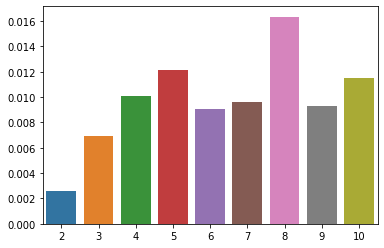

In [26]:
sns.barplot(x=list(result_mean.keys()), y=list(result_mean.values()))

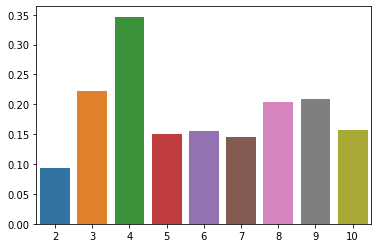

In [27]:
sns.barplot(x=list(result_max.keys()), y=list(result_max.values()))

**Nhận xét**: 

Kết quả **Average R precision** giảm dần khi giá trị fraction tăng từ 2 - 10, tức là số lượng bài hát input dùng để đề xuất càng nhiều thì model hoạt động càng tốt. Tuy nhiên nhìn chung **Average R precision** vẫn còn khá thấp (< 1 %), tức là tỷ lệ đề xuất trung bình 

Kết quả **Max R precision** biến động hơn so với giá trị **Average R precision**, có một số playlist đề xuất được đúng khá nhiều bài hát (**Max R precision** khi **fraction = 2** lên tới gần 0.06).